# VAMP Score Code

## Define Simulations

In [1]:
import numpy as np
import torch


# LANGEVIN DYNAMICS

def vvel_lng_batch(x, v, a, drag, T, dt, nsteps):
    """ Langevin dynamics with Velocity-Verlet.
    Batched version: compute multiple trajectories in parallel
    This function mutates the position (x) and velocity(v) arrays.
    Compute nsteps updates of the system: We're passed x(t=0) and v(t=0) and
    return x(dt*nsteps), v(dt*nsteps). Leapfrog updates are used for the intermediate steps.
    a(x) is the acceleration as a function of the position.
    drag[] is a vector of drag coefficients to be applied to the system.
    T is the temperature in units of energy.
    dt is the timestep size.
    Shapes:
    x: (batch, coorddim)
    v: (batch, coorddim)
    drag: (coorddim,)
    a: (-1, coorddim) -> (-1, coorddim)
    return = x:(batch, coorddim), v:(batch, coorddim)"""
    assert nsteps >= 1
    assert x.shape == v.shape and drag.shape == x.shape[1:]
    noise_coeffs = np.sqrt(2*drag*T*dt) # noise coefficients for a dt timestep
    def randn():
        return np.random.randn(*x.shape)
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    for i in range(nsteps - 1):
        x += dt*v
        v += dt*(a(x) - drag*v) + noise_coeffs*randn()
    x += dt*v
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    return x, v


class TrajectorySim:
    def __init__(self, acc_fn, drag, T, delta_t, t_res):
        """ Object representing a physical system for which we can generate trajectories.
        acc_fn : function defining the system, gives acceleration given position
        drag : vector of drag coefficients, also gives the shape of the position vector
        T : temperature
        delta_t : time spacing at which we take samples
        t_res : time resolution, number of individual simulation steps per delta_t """
        self.acc_fn = acc_fn
        self.drag = drag
        self.T = T
        self.delta_t = delta_t
        self.t_res = t_res
        self.dt = delta_t/t_res
        self.dim = drag.flatten().shape[0]
    def generate_trajectory(self, batch, N, initial_x=None, initial_v=None):
        x_traj = np.zeros((batch, N, self.dim))
        v_traj = np.zeros((batch, N, self.dim))
        if initial_x is None: initial_x = np.zeros((batch,) + self.drag.shape)
        if initial_v is None: initial_v = np.zeros((batch,) + self.drag.shape)
        x = initial_x.copy()
        v = initial_v.copy()
        for i in range(N):
            vvel_lng_batch(x, v, self.acc_fn, self.drag, self.T, self.dt, self.t_res)
            x_traj[:, i] = x
            v_traj[:, i] = v
        return x_traj, v_traj




# POLYMER (LINEAR CHAIN)
polymer_length = 12

def get_polymer_a(k, n, dim=3):
    """ Get an acceleration function defining a polymer system with n atoms and spring constant k
    Shapes:
    x: (batch, n*dim)
    a: (batch, n*dim) """
    def a(x):
        x = x.reshape(-1, n, dim)
        ans = np.zeros_like(x)
        ans[:, 1:] += k*(x[:, :-1] - x[:, 1:])
        ans[:, :-1] += k*(x[:, 1:] - x[:, :-1])
        return ans.reshape(-1, n*dim)
    return a


sims = {
    "1D Ornstein Uhlenbeck": TrajectorySim(
        (lambda x: -x),
        np.array([10.]), 1.0,
        3.0, 60
    ),
    "1D Polymer, Ornstein Uhlenbeck": TrajectorySim(
        get_polymer_a(1.0, polymer_length, dim=1),
        np.array([10.]*polymer_length), 1.0,
        1.0, 20
    ),
}


# DATASET GENERATION
def get_dataset(sim, N, L, device="cpu"):
    dataset = np.zeros((N, L, sim.dim)) # just training on position coordinates for now. training on velocity too makes dim twice as large
    t_eql = 120 # number of delta_t to wait to system to equilibriate, data before this point is thrown away
    x_traj, _ = sim.generate_trajectory(N, L+t_eql)
    dataset = x_traj[:, t_eql:]
    return torch.tensor(dataset, dtype=torch.float32, device=device)


# COMPUTE THE THEORETICAL EIGENVALUE #1 FOR THE 1D PROCESS
# v' = -x - drag*v + noise
# if we average out the noise, and set v' = 0, we get: v = -x/drag
# x' = v = -x/drag
# x = exp(-t/drag)
def get_ou_eigen_1d():
  sim = sims["1D Ornstein Uhlenbeck"]
  return np.exp(-sim.delta_t/sim.drag[0])

# similar, but now v is -kx/drag, where k is associated with a Rouse mode
# we'll let the user of this function worry about the value of k, though
def get_poly_eigen_1d():
  sim = sims["1D Polymer, Ornstein Uhlenbeck"]
  return np.exp(-sim.delta_t/sim.drag[0])

if True:
  print("Linear eigenstate decay per time delta_t for 1D Ornstein Uhlenbeck:", get_ou_eigen_1d())
  print("Linear eigenstate decay per time delta_t for Polymer (assuming reference of k=1):", get_poly_eigen_1d())


Linear eigenstate decay per time delta_t for 1D Ornstein Uhlenbeck: 0.7408182206817179
Linear eigenstate decay per time delta_t for Polymer (assuming reference of k=1): 0.9048374180359595


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# DECORRELATION
class Affine:
    """ Class representing an affine transformation in n-dimensional space """
    def __init__(self, W, mu):
        self.W = W
        self.mu = mu
    def __call__(self, x):
        return (self.W @ (x - self.mu).T).T

def decorr(x, with_transform=True, epsilon=1e-6):
    """ decorrelate (i.e. apply a whitening transformation) to the data vector x with shape (batch, featuredim)
    dimensions where there is no variation will be discarded """
    batch, featuredim = x.shape
    mu = x.mean(0, keepdim=True)
    x = x - mu
    C = torch.cov(x.T)
    lam, Q = torch.linalg.eigh(C)
    keepdim_mask = lam > epsilon # discard dimensions where there is little variation (can't take -0.5 power of non-positive number)
    Q = Q[:, keepdim_mask]
    lam = lam[keepdim_mask]
    W = (1./torch.sqrt(lam)).reshape(-1, 1) * Q.T
    y = (W @ x.T).T
    if with_transform:
        return y, Affine(W, mu)
    return y


# VAMP SCORE
def vamp_score(chi_0, chi_1, mode="score", epsilon=1e-6):
    """ function computing the VAMP-2 score, implemented in torch for differentiability
    chi_0 - right feature vector, shape is (batch, featuredim)
    chi_1 - left feature vector, shape is (batch, featuredim)
    mode - one of several options:
        * "score": return the VAMP score directly (i.e. the Frobenius norm of the matrix)
        * "matrix": just return the estimated truncated Koopman operator (in f,g space) C_10
        * "all": return the decorrelation transformations, and also C_10
    epsilon - eigenvalues of covariance matrix are clipped to be at least this, for numberical stability """
    batch, featuredim = chi_0.shape
    assert chi_1.shape == chi_0.shape
    f, trans_0 = decorr(chi_0) # f.shape: (batch, truncdim_f <= featuredim)
    g, trans_1 = decorr(chi_1) # g.shape: (batch, truncdim_g <= featuredim)
    # compute covariance
    C_aa = torch.cov(torch.cat([f.T, g.T], dim=0))
    C_10 = C_aa[f.shape[1]:, :f.shape[1]] # estimated truncated Koopman operator
    if mode == "score":
        return (C_10**2).sum()
    elif mode == "matrix":
        return C_10
    elif mode == "all":
        return trans_0, trans_1, C_10
    else:
        assert False, "invalid mode passed"


# POWER FEATURES
def get_powers_of_x(x):
    """ powers of x where x.shape == (batch, 1) """
    x_powers = [x]
    for i in range(3):
        x_powers.append(x*x_powers[-1])
    return torch.cat(x_powers, dim=1)


# ANALYZE 1D HARMONIC WITH POWER FEATURES
def analyze_with_powers(dataset):
    N, L, _ = dataset.shape
    chi_0 = get_powers_of_x(dataset[:N, :-1].reshape(N*(L-1), -1))
    chi_1 = get_powers_of_x(dataset[:N, 1: ].reshape(N*(L-1), -1))
    # apply vamp score
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    # analyze results using SVD
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    eigenfn_0 = lambda x: trans_0(get_powers_of_x(x))
    eigenfn_1 = lambda x: trans_1(get_powers_of_x(x))
    return S, eigenfn_0, eigenfn_1

# ANALYZE BY COMPARING WITH THE EXPECTED HERMITE POLYNOMIALS

hermites = torch.tensor([
    [1., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0.],
    [-1., 0., 1., 0., 0.],
    [0., -3., 0., 1., 0.],
    [3., 0., -6., 0., 1.],
])
def poly_eval(x, poly):
    deg = len(poly)
    powers = x[:, None] ** torch.arange(deg)[None, :]
    return (poly*powers).sum(-1)
def plot_hermites(ax, x, scalings=None):
    if scalings is None or scalings == "ortho":
        # normalization for H_n is inverse square root of n! (that was a factorial)
        scalings = torch.exp(-0.5*torch.lgamma(1 + torch.arange(hermites.shape[0])))
    elif scalings == "ones":
        scalings = torch.ones(hermites.shape[0])
    for i, hermite in enumerate(hermites):
        ax.plot(x, poly_eval(x, hermite*scalings[i]), color="black", linestyle="--")


# TRAIN VAMPNET FOR 1D HARMONIC OU PROCESS
# some hyperparameters:
lr = 0.0001


def res_init(module):
    with torch.no_grad():
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None: module.bias.data.fill_(0.0)

class ResLayer(nn.Module):
    def __init__(self, dim):
        super(ResLayer, self).__init__()
        self.dim = dim
        self.layers = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.2),
            nn.Linear(dim, dim),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(dim, dim, bias=False),
        )
        self.apply(res_init)
    def forward(self, x):
        return x + self.layers(x)

def res_layer_weight_decay(model, coeff=0.1):
    """ weight decay only for weights in ResLayer's """
    params = []
    for m in model.modules():
        if isinstance(m, ResLayer):
            for layer in m.layers:
                if isinstance(layer, nn.Linear):
                    params.append(layer.weight)
                    if layer.bias is not None:
                        params.append(layer.bias)
    return coeff * sum((param**2).sum() for param in params)

class VAMPNet(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(VAMPNet, self).__init__()
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.layers = nn.Sequential(
            nn.Linear(inp_dim, 512),
            ResLayer(512),
            ResLayer(512),
            ResLayer(512),
            nn.Linear(512, 512),
            ResLayer(512),
            ResLayer(512),
            ResLayer(512),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.layers(x)

def make_VAMPNet(dataset, out_dim=16, device="cuda"):
    N, L, dim = dataset.shape
    model = VAMPNet(dim, out_dim).to(device)
    #print(model)
    return model

def train_VAMPNet(model, dataset, epochs, device="cuda", batch=5000, weight_decay=None):
    """ train a VAMPNet for a particular system
    dataset - array of trajectories, shape is (N, L, dim)
    N - number of trajectories to create
    L - length of each trajectory """
    dataset = dataset.to(device)
    N, L, dim = dataset.shape
    optimizer = torch.optim.Adam(model.parameters(), lr)
    for i in range(epochs):
        print("epoch", i)
        for t in range(L - 1):
            for j in range(0, N, batch):
                input_coords_0 = dataset[j:j+batch, t]
                input_coords_1 = dataset[j:j+batch, t + 1]
                model.zero_grad()
                chi_0 = model.forward(input_coords_0)
                chi_1 = model.forward(input_coords_1)
                loss = -vamp_score(chi_0, chi_1)
                if weight_decay is not None:
                    loss = loss + res_layer_weight_decay(model, weight_decay)
                #print("   step", j, ": loss =", float(loss.detach().to("cpu")))
                loss.backward()
                optimizer.step()
    return model


# POLYMER DATASET
def subtract_cm_1d(dataset):
    """ given a polymer dataset, subtract the mean position (center of mass) of the polymer
        for each position in the dataset. Polymer should be 1d. Inputs:
        dataset: (N, L, polymer_length) """
    return dataset - dataset.mean(2)[:, :, None]


def analyze_tica(dataset):
    N, L, _ = dataset.shape
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = dataset[:N, :-1].reshape(N*(L-1), -1)
    chi_1 = dataset[:N, 1: ].reshape(N*(L-1), -1)
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    return S, trans_0, trans_1


def tica_theory(n):
    return np.exp(np.log(get_poly_eigen_1d())*4*(np.sin(0.5*np.pi*n/polymer_length))**2)


# 2 QUANTA THEORY
def get_2_quanta_theory():
    S_0d = np.ones(1)
    S_1d = tica_theory(np.arange(polymer_length)[1:])
    S_2d = np.outer(S_1d, S_1d)[np.triu_indices(polymer_length - 1)]
    S_expected = np.concatenate([S_0d, S_1d, S_2d])
    S_expected = np.sort(S_expected)[::-1]
    return S_expected


# ARBITRARY QUANTA THEORY (THE IDEALISTIC THEORY)
def get_log_expected_singular_values(log_vals, n, show_ans_tups=False):
    """ get the expected singular values where arbitrary numbers
        of quanta can be put into a given mode
        log_vals: logarithms of the value for 1 quanta in a given mode.
                  Should be sorted in increasing order!
        n: we'll compute the largest (least negative) n singular values """
    def H(tup): # energy function
        return sum([tup[i]*log_vals[i] for i in range(dim)])
    dim = len(log_vals)
    ans_tups = [tuple([0]*dim)]
    for i in range(n):
        # get a list of candidates for the next largest tuple
        # a candidate must not be an existing tuple
        # all candidates are increments of some existing tuple
        candidate_tups = []
        for tup in ans_tups:
            for j in range(dim):
                lst = list(tup)
                lst[j] += 1
                inc_tup = tuple(lst)
                if inc_tup not in ans_tups:
                    candidate_tups.append(inc_tup)
                    break
        # find and add to the list the largest of the candidates
        i_best = 0
        H_best = -np.inf
        for i, tup in enumerate(candidate_tups):
            if H(tup) > H_best:
                i_best = i
                H_best = H(tup)
        ans_tups.append(candidate_tups[i_best])
    if show_ans_tups:
        for tup in ans_tups: print(tup)
    return [H(tup) for tup in ans_tups]

def get_n_quanta_theory(num_values):
    log_lin_S = np.log(tica_theory(1 + np.arange(polymer_length - 1)))
    return np.exp(get_log_expected_singular_values(log_lin_S, num_values))


# FEATURES ARE DEGREE 2 POLYNOMIALS
def batch_triu(x):
    """ given a tensor x of shape (batch, n, n), returns a
        tensor of shape (batch, n*(n+1)/2) where ans[i] is a
        flattened array of the upper triangular entries of x[i] """
    batch, n, m = x.shape
    assert n == m
    triu_indices = torch.triu_indices(n, n)
    triu_indices = n*triu_indices[0] + triu_indices[1] # prepare the indices for flattened dim
    return torch.index_select(x.reshape(batch, n*n), 1, triu_indices)

def get_degree_2(x):
    """ powers of x up to degree 2 where x.shape == (batch, n)
        output has shape (batch, n*(n+1)/2) """
    batch, n = x.shape
    outer = x.reshape(batch, n, 1) * x.reshape(batch, 1, n)
    return torch.cat([
        x,
        batch_triu(outer)
    ], dim=1)


# DEGREE 2 / 2 QUANTA ANALYSIS
def analyze_with_degree_2(dataset):
    N, L, _ = dataset.shape
    chi_0 = get_degree_2(dataset[:N, :-1].reshape(N*(L-1), -1))
    chi_1 = get_degree_2(dataset[:N, 1: ].reshape(N*(L-1), -1))
    # apply vamp score
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    # analyze results using SVD
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    eigenfn_0 = lambda x: trans_0(get_degree_2(x))
    eigenfn_1 = lambda x: trans_1(get_degree_2(x))
    return S, eigenfn_0, eigenfn_1


# UTILITY FUNCTION:
def batched_model_eval(model, input, batch=16384):
    """ to avoid running out of memory, evaluate the model on a large tensor in batches
        Should only be called within torch.no_grad() context!
        model - the pytorch model to evaluate
        input - the input we are feeding to the model. shape: (N, channels)
        returns: the result of evaulating the model. shape: (N, out_chan) """
    N, channels = input.shape
    ans = torch.zeros(N, model.out_dim, device=input.device)
    for i in range(0, N, batch):
        ans[i:i+batch] = model(input[i:i+batch])
    return ans

# ANALYZE
def analyze_with_nn_model(model, dataset, G=None, eval_batch=16384):
    model.eval()
    dataset = dataset.to("cuda")
    with torch.no_grad():
        N, L, _ = dataset.shape
        chi = batched_model_eval(model, # just evaluate once, since it's the same model
                                 dataset.reshape(N*L, -1),
                                 batch=eval_batch)
        chi_0 = chi.reshape(N, L, -1)[:, :-1].reshape(N*(L-1), -1)
        chi_1 = chi.reshape(N, L, -1)[:, 1: ].reshape(N*(L-1), -1)
        trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
        K = K.detach()
        U, S, Vh = torch.linalg.svd(K)
        if G is not None: # only keep top G singular values
            U, S, Vh = U[:, :G], S[:G], Vh[:G]
        trans_0 = Affine( Vh @ trans_0.W.detach(), trans_0.mu.detach())
        trans_1 = Affine(U.T @ trans_1.W.detach(), trans_1.mu.detach())
        eigenfn_0 = lambda x: trans_0(model(x))
        eigenfn_1 = lambda x: trans_1(model(x))
        return S, eigenfn_0, eigenfn_1




In [37]:
# 1D HARMONIC DATASET
print("generating 1d dataset...")
dataset_1d = get_dataset(sims["1D Ornstein Uhlenbeck"], 10000, 100)
print("done.")

generating 1d dataset...
done.


In [71]:
if True:
    model_1d = make_VAMPNet(dataset_1d, 5)
    train_VAMPNet(model_1d, dataset_1d, 20, weight_decay=0.1)
    train_VAMPNet(model_1d, dataset_1d, 4, weight_decay=0.03)
    train_VAMPNet(model_1d, dataset_1d, 4, batch=10000)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 0
epoch 1
epoch 2
epoch 3
epoch 0
epoch 1
epoch 2
epoch 3


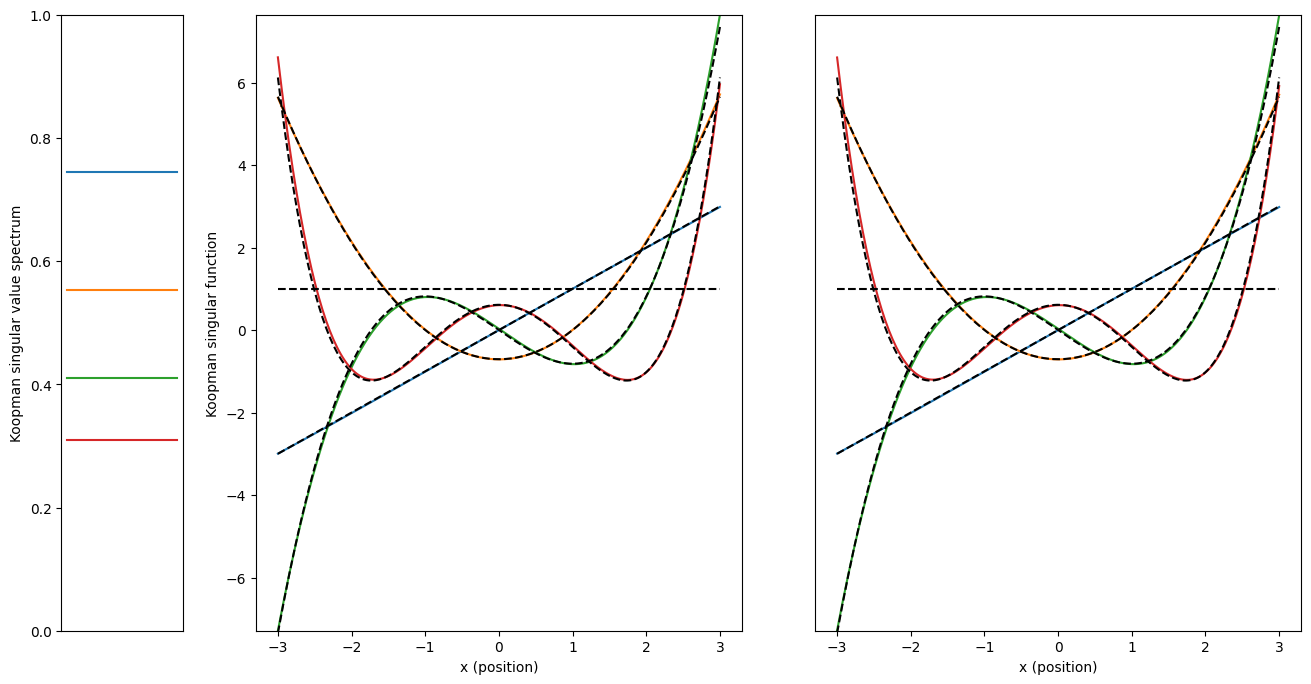

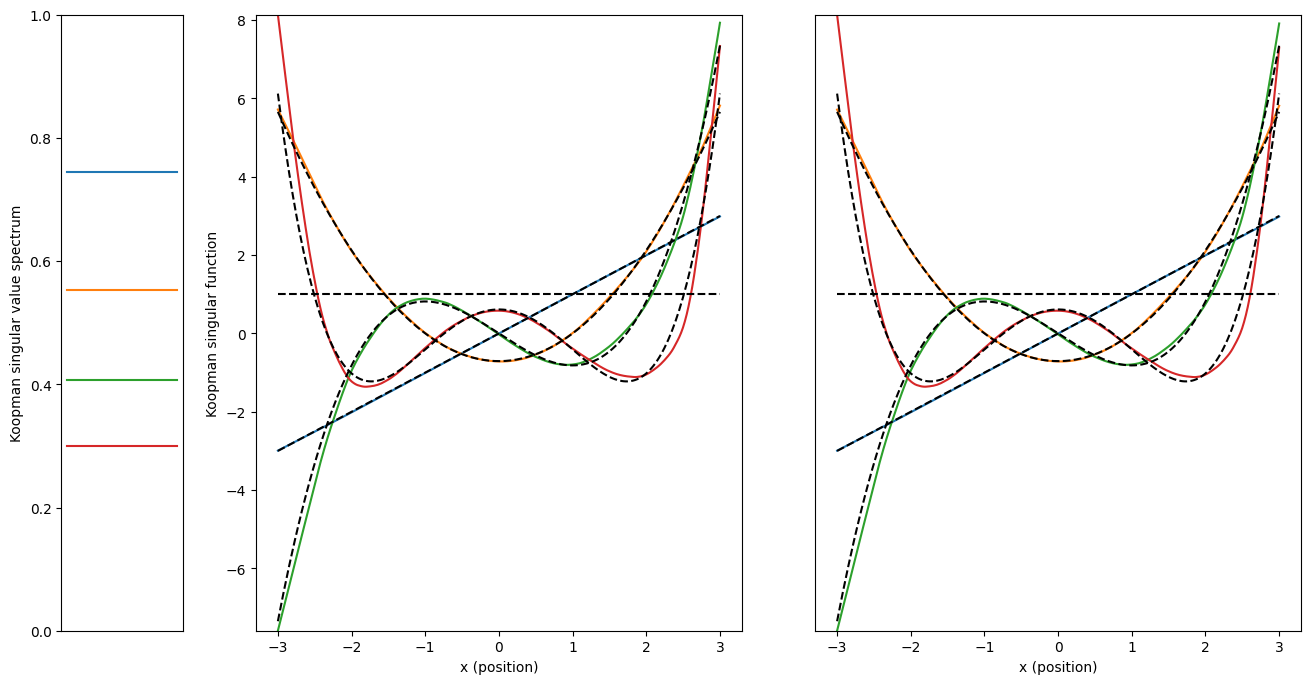

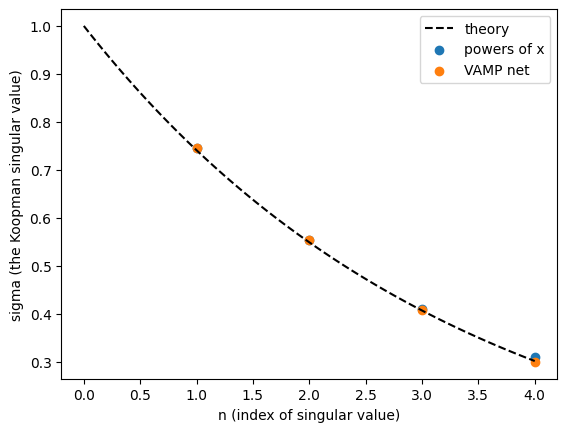

In [72]:
def make_fig_1d(name, S, eigenfn_0, eigenfn_1, with_hermites=True):
    x = torch.linspace(-3., 3., 240).reshape(240, 1)
    ef_0 = eigenfn_0(x)
    ef_1 = eigenfn_1(x)
    # reorient eigenfunctions so they're always increasing for large x (makes comparison with Hermite polynomials easier)
    signs = np.sign(ef_0[-1])[None, :]
    ef_0 *= signs
    ef_1 *= signs
    # do plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, width_ratios=[1, 4, 4], figsize=(16, 8))
    x1, y1 = np.array([0., 1.]), np.array([1., 1.])
    for i, sigma in enumerate(S):
        ax1.plot(x1, sigma*y1)
        ax2.plot(x, ef_0[:, i])
        ax3.plot(x, ef_1[:, i])
    if with_hermites:
        plot_hermites(ax2, x, "ortho")
        plot_hermites(ax3, x, "ortho")
    ax1.set_ylim(0., 1.)
    ax1.get_xaxis().set_visible(False)
    ymin, ymax = min(ef_0.min(), ef_1.min()), max(ef_0.max(), ef_1.max())
    ax2.set_ylim(ymin, ymax)
    ax3.set_ylim(ymin, ymax)
    ax3.get_yaxis().set_visible(False)
    ax1.set_ylabel("Koopman singular value spectrum")
    ax2.set_ylabel("Koopman singular function")
    ax2.set_xlabel("x (position)")
    ax3.set_xlabel("x (position)")
    plt.show()

def plot_spectrum_1d(S_list, labels, G=4):
        x = np.linspace(0, G, 100)
        theory = np.exp(x*np.log(get_ou_eigen_1d()))
        plt.plot(x, theory, color="black", linestyle="--", label="theory")
        for i in range(len(S_list)):
            n = 1 + np.arange(G)
            plt.scatter(n, S_list[i], label=labels[i])
        plt.legend()
        plt.xlabel("n (index of singular value)")
        plt.ylabel("sigma (the Koopman singular value)")
        plt.show()

if True:
    # ANALYZE AND CREATE FIGURE
    S_1d_powers, eigenfn_0_1d_powers, eigenfn_1_1d_powers = analyze_with_powers(dataset_1d)
    make_fig_1d("1d_powers", S_1d_powers, eigenfn_0_1d_powers, eigenfn_1_1d_powers)
    S_1d_vampnet, eigenfn_0_1d_vampnet_dev, eigenfn_1_1d_vampnet_dev = analyze_with_nn_model(model_1d, dataset_1d, G=4)
    S_1d_vampnet = S_1d_vampnet.to("cpu")
    eigenfn_0_1d_vampnet = lambda x: eigenfn_0_1d_vampnet_dev(x.to("cuda")).detach().to("cpu")
    eigenfn_1_1d_vampnet = lambda x: eigenfn_1_1d_vampnet_dev(x.to("cuda")).detach().to("cpu")
    make_fig_1d("1d_vampnet", S_1d_vampnet, eigenfn_0_1d_vampnet, eigenfn_1_1d_vampnet)
    # NOW WE PLOT THE SPECTRA
    plot_spectrum_1d([S_1d_powers, S_1d_vampnet], ["powers of x", "VAMP net"])


In [3]:
# GAUSSIAN CHAIN DATASET
print("generating polymer dataset...")
dataset_poly = subtract_cm_1d(get_dataset(sims["1D Polymer, Ornstein Uhlenbeck"], 80000, 80))
print("done.")

generating polymer dataset...
done.


In [4]:
# TRAIN VAMPNETS FOR GAUSSIAN CHAIN
model_poly = make_VAMPNet(dataset_poly, 24)
train_VAMPNet(model_poly, dataset_poly, 16, weight_decay=0.01)
train_VAMPNet(model_poly, dataset_poly, 4, weight_decay=0.003)
train_VAMPNet(model_poly, dataset_poly, 4, batch=10000)
if True:
    model_poly_large = make_VAMPNet(dataset_poly, 100)
    train_VAMPNet(model_poly_large, dataset_poly, 16, weight_decay=0.01)
    train_VAMPNet(model_poly_large, dataset_poly, 4, weight_decay=0.003)
    train_VAMPNet(model_poly_large, dataset_poly, 4, batch=10000)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 0
epoch 1
epoch 2
epoch 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 0
epoch 1
epoch 2
epoch 3
epoch 0
epoch 1
epoch 2
epoch 3


torch.Size([80000, 80, 12])


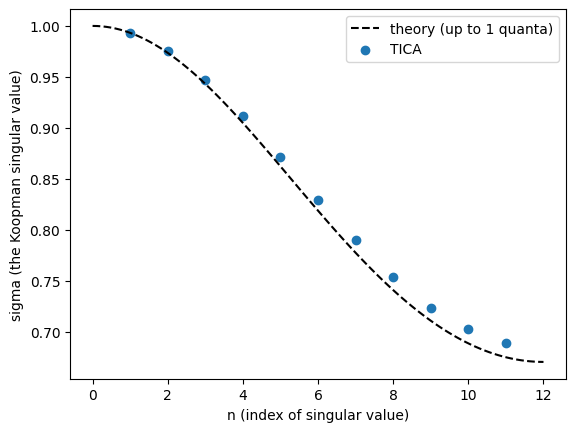

OutOfMemoryError: CUDA out of memory. Tried to allocate 580.00 MiB. GPU 0 has a total capacty of 11.72 GiB of which 232.81 MiB is free. Including non-PyTorch memory, this process has 11.48 GiB memory in use. Of the allocated memory 11.22 GiB is allocated by PyTorch, and 35.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:

def plot_spectrum_poly_tica(S):
    x = np.linspace(0., polymer_length, 100)
    plt.plot(x, tica_theory(x), color="black", linestyle="--", label="theory (up to 1 quanta)")
    plt.scatter(np.arange(len(S)) + 1, S, label="TICA")
    plt.legend()
    plt.xlabel("n (index of singular value)")
    plt.ylabel("sigma (the Koopman singular value)")
    plt.show()

def plot_spectrum_poly_all(nmax, S_list, labels):
    """ nmax is length of the x axis (number of singular values to show) """
    x = np.linspace(0., polymer_length, 100)
    plt.plot(x, tica_theory(x), color="black", linestyle="--", label="theory (up to 1 quanta)")
    for i in range(len(S_list)):
        plt.scatter(1 + np.arange(len(S_list[i])), S_list[i], label=labels[i])
    S_theory_deg2 = get_2_quanta_theory()
    plt.scatter(np.arange(len(S_theory_deg2)), S_theory_deg2, color="dimgrey", label="theory (up to 2 quanta)")
    S_theory_degn = get_n_quanta_theory(nmax)
    plt.scatter(np.arange(len(S_theory_degn)), S_theory_degn, color="black", label="theory (any number of quanta)")
    plt.legend()
    plt.xlabel("n (index of singular value)")
    plt.ylabel("sigma (the Koopman singular value)")
    plt.show()


if True:
    print(dataset_poly.shape)
    S_poly_tica, eigenfn_0_poly_tica, eigenfn_1_poly_tica = analyze_tica(dataset_poly)
    plot_spectrum_poly_tica(S_poly_tica)
    S_poly_deg2, *_ = analyze_with_degree_2(dataset_poly)
    S_poly_nn, eigenfn_0_poly_nn_dev, eigenfn_1_poly_nn_dev = analyze_with_nn_model(model_poly, dataset_poly)
    S_poly_nn = S_poly_nn.to("cpu")
    #S_poly_nn_large, *_ = analyze_with_nn_model(model_poly_large, dataset_poly)
    #S_poly_nn_large = S_poly_nn_large.to("cpu")
    plot_spectrum_poly_all(100,
        [S_poly_tica, S_poly_deg2, S_poly_nn],
        ["TICA", "degree 2 feature analysis", "VAMP net d=24"])



(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
(2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
(3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)

tica comparison plot 0:


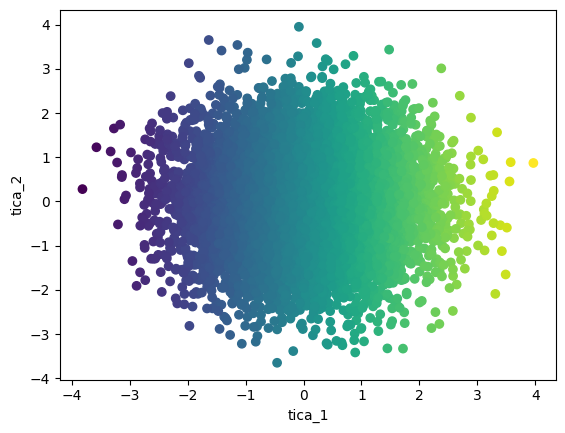


tica comparison plot 1:


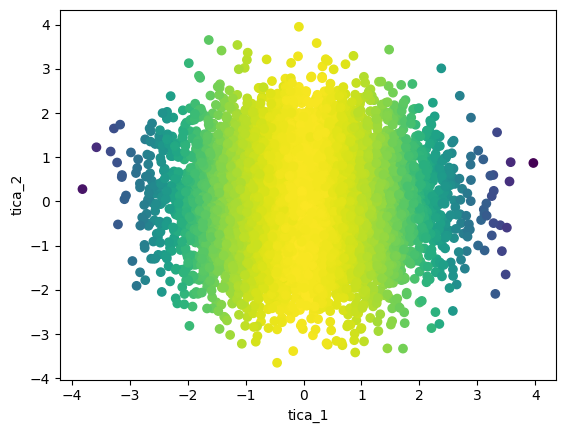


tica comparison plot 2:


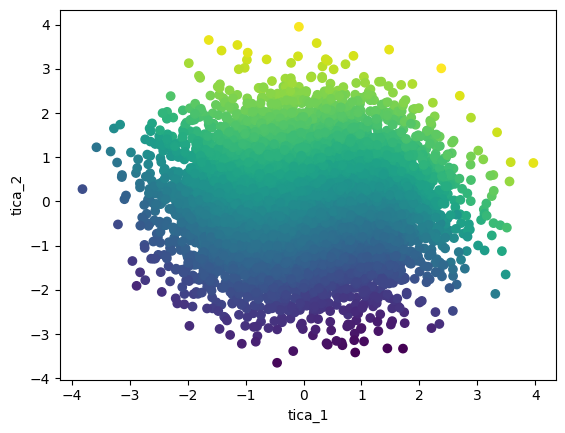


tica comparison plot 3:


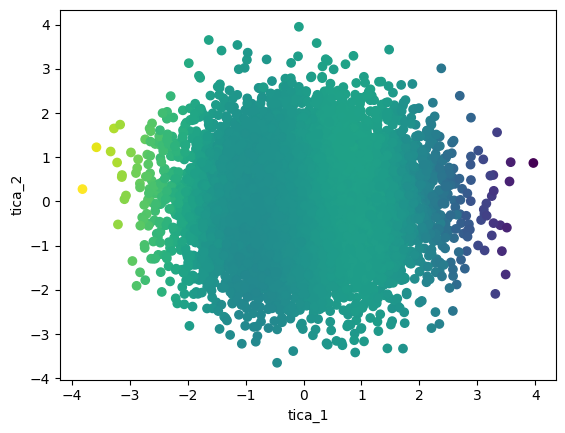


tica comparison plot 4:


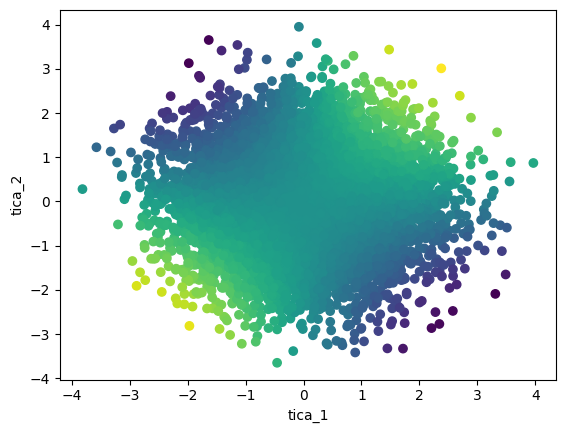


tica comparison plot 5:


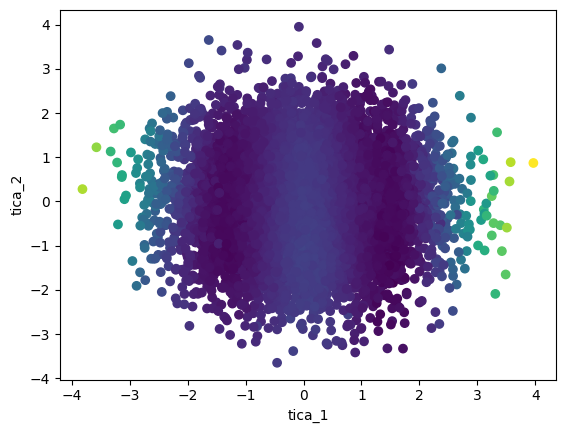


tica comparison plot 6:


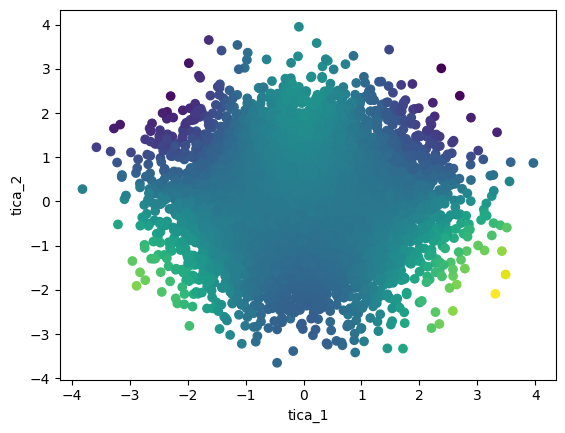


tica comparison plot 7:


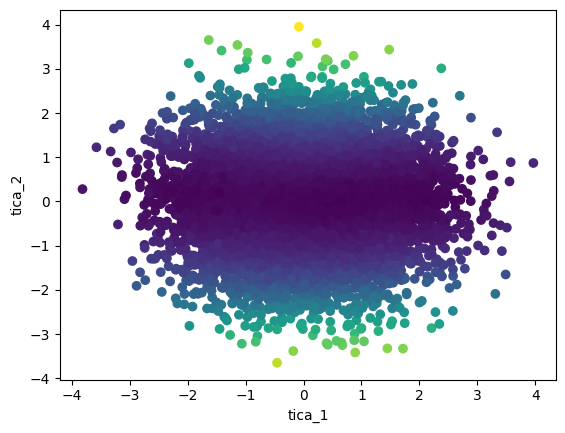


tica comparison plot 8:


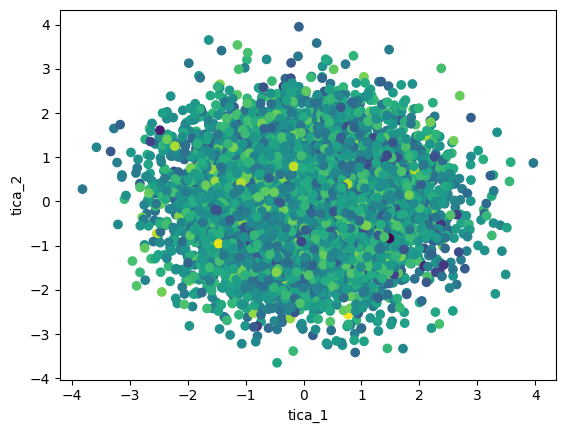


tica comparison plot 9:


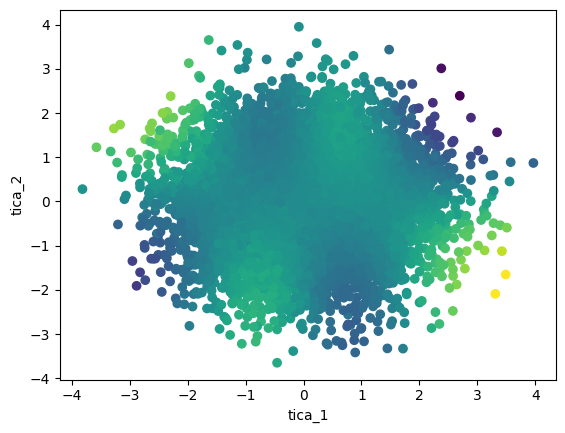


tica comparison plot 10:


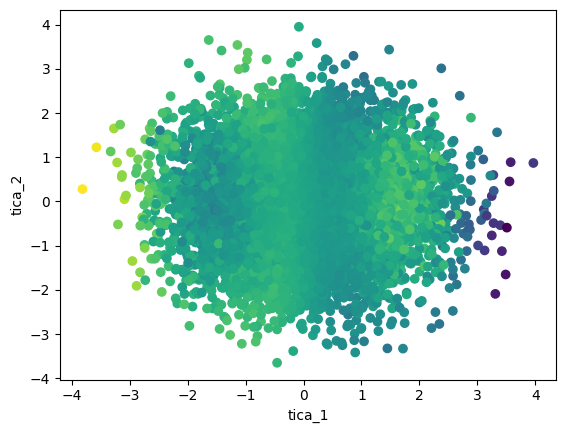


tica comparison plot 11:


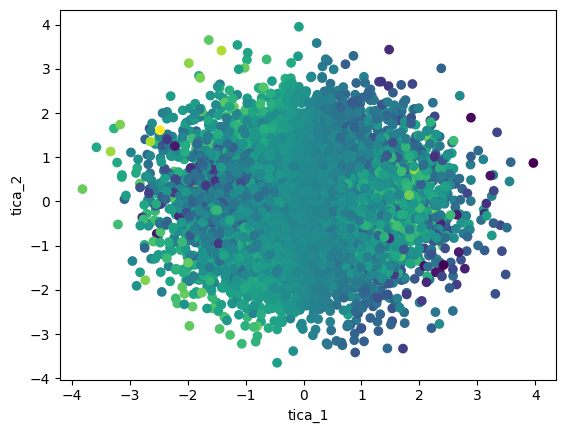


tica comparison plot 12:


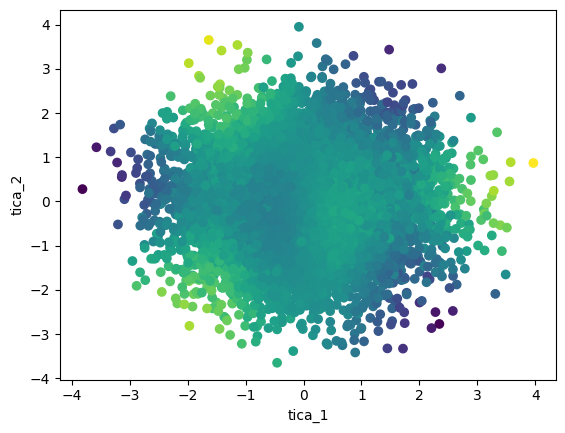


tica comparison plot 13:


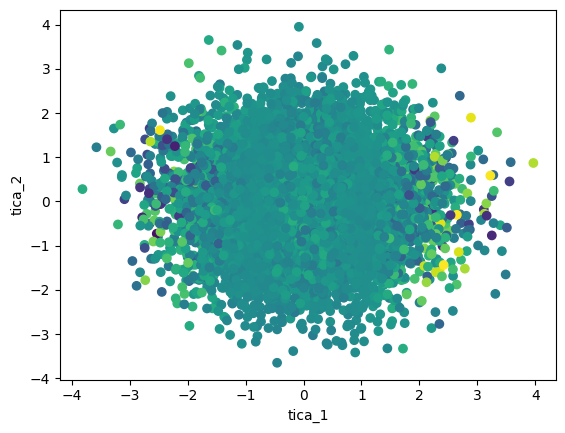


tica comparison plot 14:


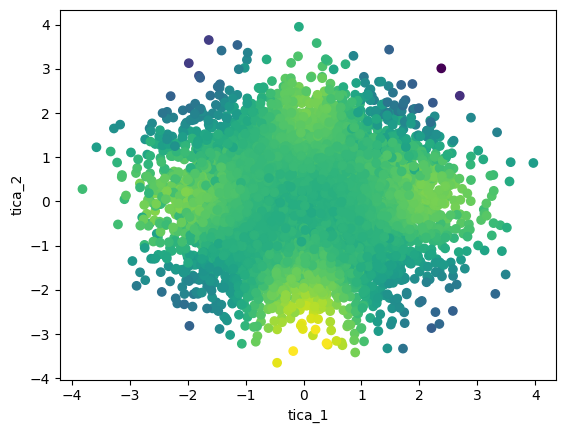


tica comparison plot 15:


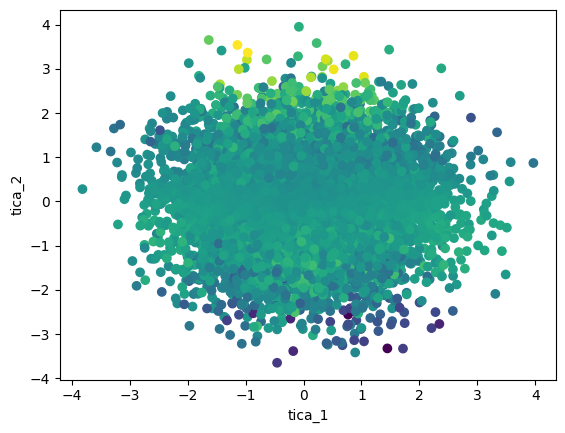


tica comparison plot 16:


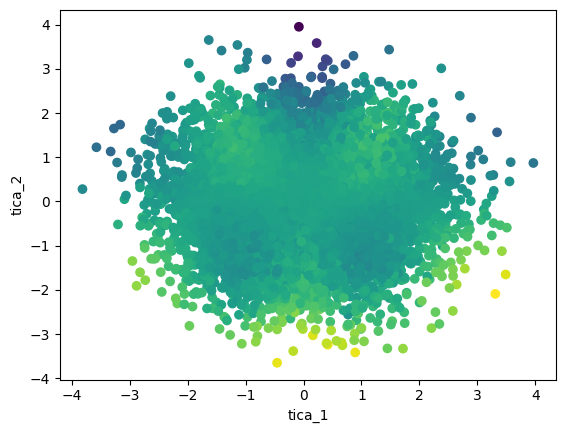


tica comparison plot 17:


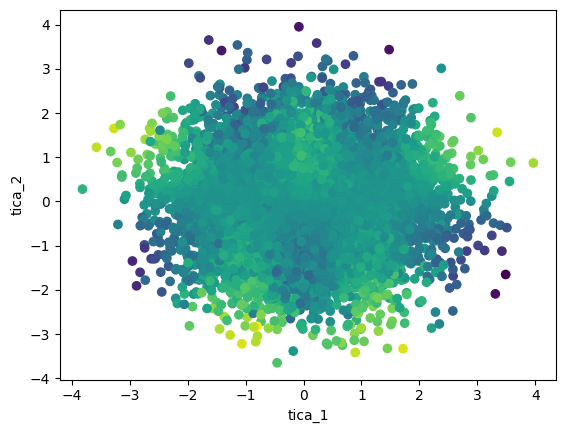


tica comparison plot 18:


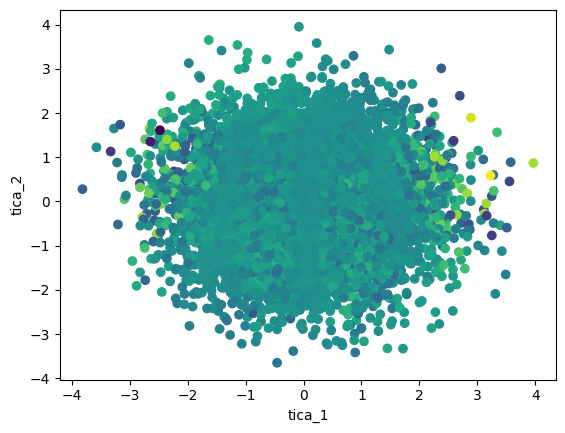


tica comparison plot 19:


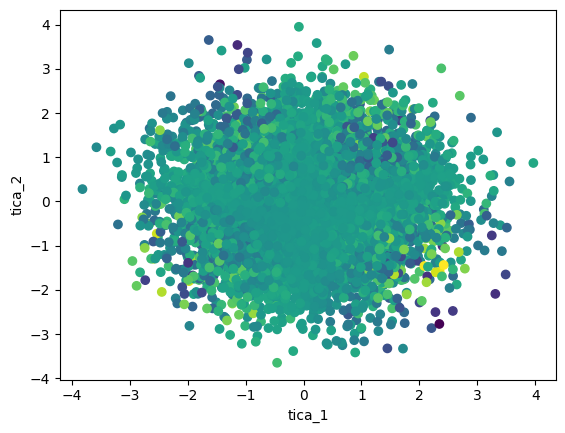


tica comparison plot 20:


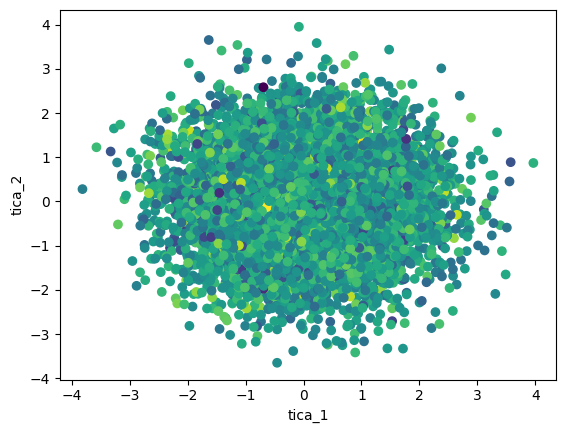


tica comparison plot 21:


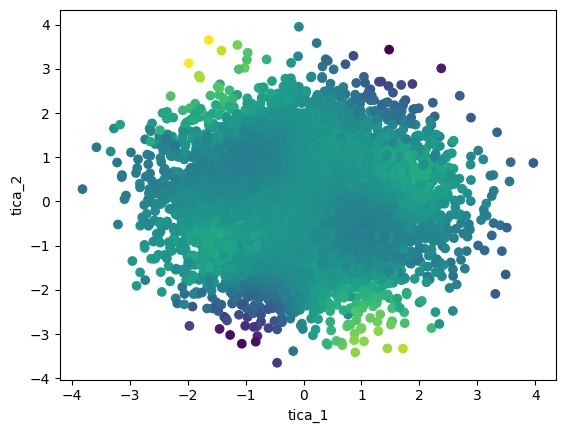


tica comparison plot 22:


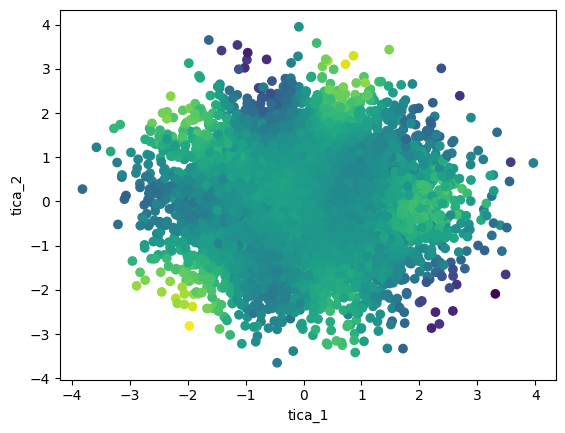


tica comparison plot 23:


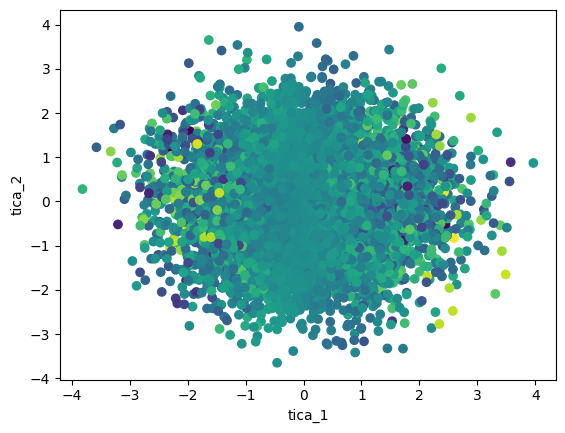

In [37]:


def tica_comparison_plot(eigenfn, idx, tica_1, tica_2, dataset):
    states = dataset[:, -1]
    x = tica_1(states)
    y = tica_2(states)
    z = eigenfn(states)[:, idx]
    plt.scatter(x, y, c=z)
    plt.xlabel("tica_1")
    plt.ylabel("tica_2")
    plt.show()

if True:
    log_lin_S = np.log(tica_theory(1 + np.arange(polymer_length - 1)))
    get_log_expected_singular_values(log_lin_S, 24, show_ans_tups=True)

if True:
    eigenfn_0_poly_nn = lambda x: eigenfn_0_poly_nn_dev(x.to("cuda")).detach().to("cpu")
    eigenfn_1_poly_nn = lambda x: eigenfn_1_poly_nn_dev(x.to("cuda")).detach().to("cpu")
    def tica_1(x):
        return eigenfn_0_poly_tica(x)[:, 0]
    def tica_2(x):
        return eigenfn_0_poly_tica(x)[:, 1]
    for i in range(24):
        print("\ntica comparison plot %d:" % i)
        tica_comparison_plot(eigenfn_0_poly_nn, i, tica_1, tica_2, dataset_poly)




torch.Size([80000, 80, 12])
